In [74]:
import json
import requests
from PIL import Image
import numpy as np
import os
from io import BytesIO
from pathlib import Path

with open('../Labels_exported_JSON/export-2019-10-26T01_40_54.832Z.json') as f:
        data = json.load(f)

output_dir = Path('../data/smoky_images')

In [75]:
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

In [76]:
# selecting the unique IDs to have the unique pictures
ids = []
ext_ids = []
idnots = []

for i in range(len(data)):
    if data[i]['External ID'] in ext_ids:
        idnots.append(data[i]['ID'])
    else :
        ext_ids.append(data[i]['External ID'])    
        ids.append(data[i]['ID'])  

In [36]:
# ids of images containing 'none' labels
# storing to optimize consequent runs
none_ids = set()

### Download only daytime images with some smoke

In [ ]:
saved_count = 0

# This section retrieves images and masks from Labelbox using JSON file
for idx, d in enumerate(data):
    img_id = d['ID']
    
    if img_id in none_ids:
        print(f'skipping img {img_id} because of None pixels')
        continue
    
    if img_id in ids:
        print("\n Downloading Image: {}, ID: {}".format(idx, img_id))
        
        response_og = requests.get(d["Labeled Data"])
        
        original_img = Image.open(BytesIO(response_og.content))

        img_shape = np.array(original_img).shape
        masks = {}

        threshold = 200

        try:
            for key, val in d['Label']['segmentationMasksByName'].items():
                response = requests.get(val)
                img = Image.open(BytesIO(response.content))
                
                # extract labels masks like 'FiresSmokes', 'OtherSmokes', 'None'
                masks[key] = np.where(np.array(img)[:, :, 3] > threshold, 255, 0)

            smoke_mask = (masks['FiresSmokes'] + masks['OtherSmokes']).clip(0, 255)
            none_mask = masks['None']
            
            mask_sum = smoke_mask.sum()
            none_sum = none_mask.sum()
            
            print(f'image index: {idx}, mask sum: {mask_sum}, none sum: {none_sum}')
            
            if none_sum > 0 or mask_sum == 0:
                none_ids.add(img_id)
                print('skipping because of None pixels or empty mask')
                continue
            else:
                print('saving')
            
            # save original image
            original_img.save(os.path.join(output_dir, f'{idx}_{img_id}_original.png'), format='png')
            
            # save the mask
            img = Image.fromarray(smoke_mask.astype(np.uint8)).convert(mode='L', dither=Image.NONE)
            img.save(os.path.join(output_dir, f'{idx}_{img_id}_mask.png'), format='png')

            saved_count += 1
        except (TypeError, TimeoutError, OSError):
            pass

In [78]:
saved_count

586

#### Printing IDs of problematic instances

In [43]:
%matplotlib inline

from shutil import copyfile
import matplotlib.pyplot as plt

Index: 38, ID: ck1nzqcvgmwhx0725buqhm3j7


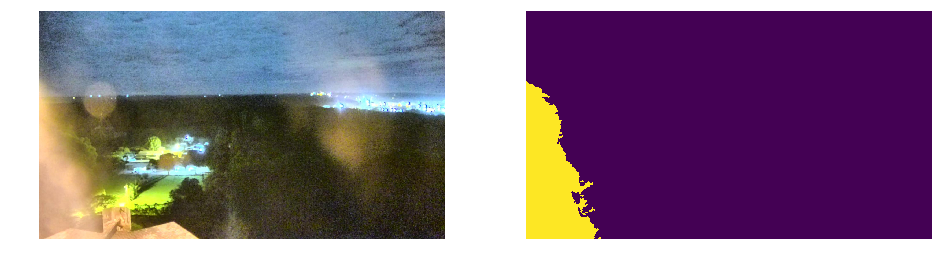

Index: 89, ID: ck1o2e7ts20md0721c3533mlu


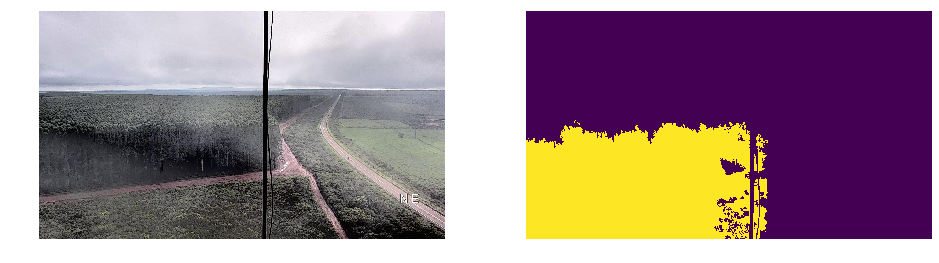

Index: 93, ID: ck1o2ift10x130944efayd5tx


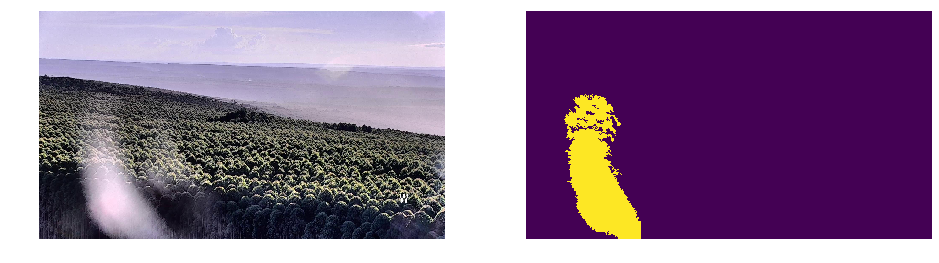

Index: 103, ID: ck1o3nv3nsp9q0748hqbivhvp


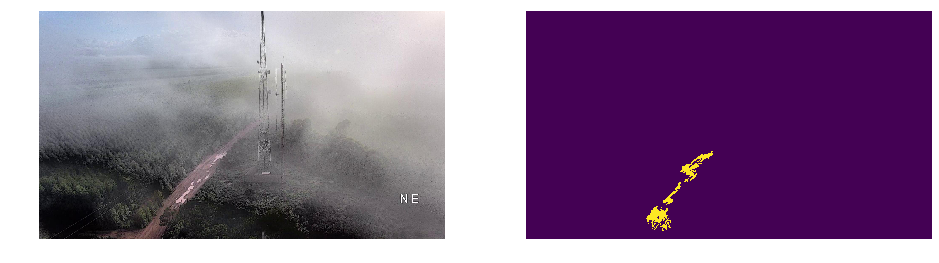

Index: 153, ID: ck1og9cm8h9re0811gy8diafd


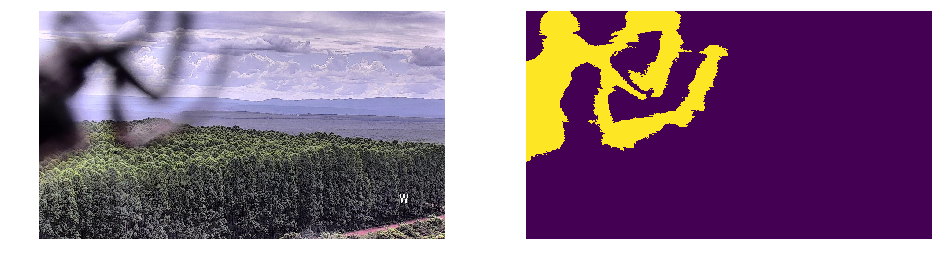

Index: 168, ID: ck1ognn5lwj8z0794h681iwni


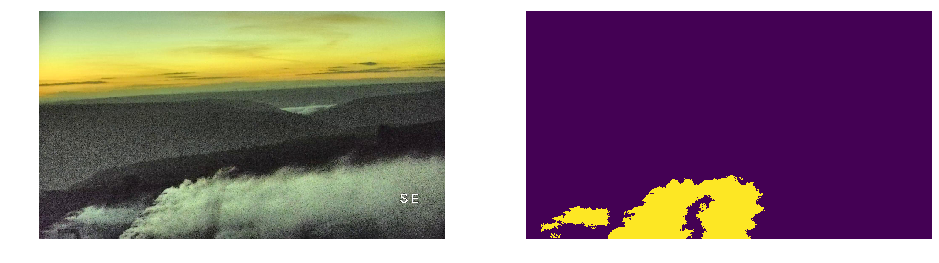

Index: 258, ID: ck1oufk9k3p6y0944kg1kzijn


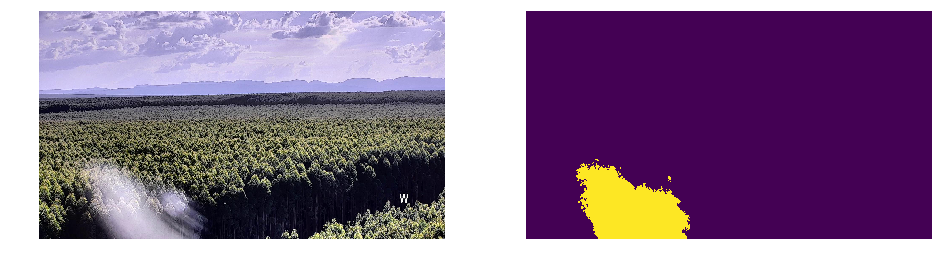

Index: 271, ID: ck1ov9osiq0vi0725qqmwmmkb


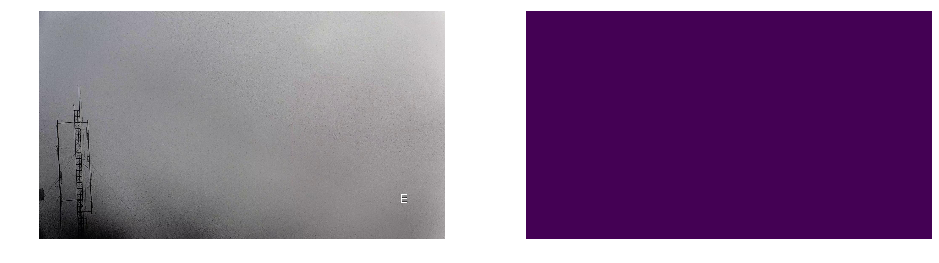

Index: 353, ID: ck1owtmx150ep0721brofqvma


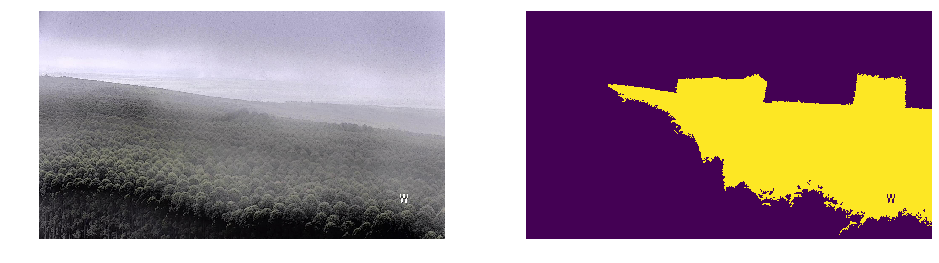

Index: 428, ID: ck1p2joyhykme07949222vx8i


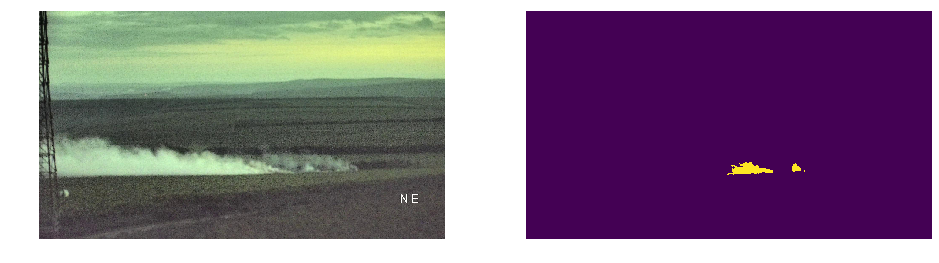

Index: 433, ID: ck1p2m6qjyl6m079442d3neao


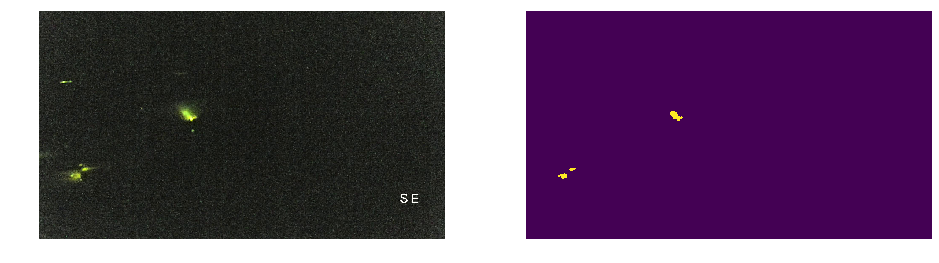

Index: 469, ID: ck1p3bw8hyp3f0794cvch375u


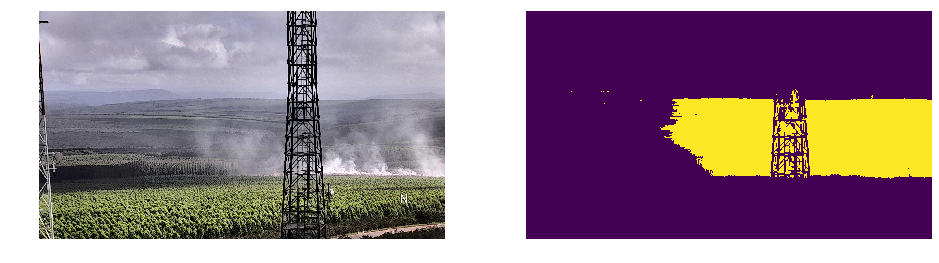

In [73]:
problematic_idxs = [38, 89, 93, 103, 153, 168, 258, 271, 353, 428, 433, 469]

def print_img(axis, img_path):
    axis.imshow(plt.imread(str(img_path)))
    axis.axis('off')

for idx, d in enumerate(data):
    img_id = d['ID']
    
    if idx not in problematic_idxs:
        continue
    
    image_file = output_dir / f'{idx}_original.png'
    mask_file = output_dir / f'{idx}_mask.png'
    
    print(f'Index: {idx}, ID: {img_id}')
    
    # print image and the mask
    f, axarr = plt.subplots(1, 2, figsize=(16, 8))
    print_img(axarr[0], image_file)
    print_img(axarr[1], mask_file)
    
    plt.show()
    